### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws
from db_queries import get_population

In [2]:
ls /mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data

binned_ldl_exposure_time.csv     risk_exposure_time.csv
binned_ldl_exposure_time.hdf     risk_exposure_time.hdf
binned_sbp_exposure_time.csv     sbp_medication_person_time.csv
binned_sbp_exposure_time.hdf     sbp_medication_person_time.hdf
deaths.csv                       state_person_time.csv
deaths.hdf                       state_person_time.hdf
healthcare_visits.csv            transition_count.csv
healthcare_visits.hdf            transition_count.hdf
intervention_person_time.csv     ylds.csv
intervention_person_time.hdf     ylds.hdf
ldlc_medication_person_time.csv  ylls.csv
ldlc_medication_person_time.hdf  ylls.hdf


In [3]:
sim_results_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_nih_us_cvd/19.5_10_draws/results_data/'

# Loading and Cleaning Data

### Load Data

In [4]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')

state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["acute_ischemic_stroke", "chronic_ischemic_stroke", "susceptible_to_ischemic_stroke"])].reset_index() 

In [5]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv').reset_index()
yll = yll.rename(columns = {'value':'yll'})
yld = pd.read_csv(sim_results_dir + 'ylds.csv').reset_index()
yld = yld.rename(columns = {'value':'yld', 'cause_of_disability':'cause'})
daly = yll.merge(yld, on = ['sex','year','cause','input_draw','scenario','age','location'], how='left')
daly['daly'] = daly.yll.fillna(0) + daly.yld.fillna(0)
daly = daly[['sex','year','cause','input_draw','scenario','age','location','yll','yld','daly']]
daly.head()

,sex,year,cause,input_draw,scenario,age,location,yll,yld,daly
0,Female,2021,acute_ischemic_stroke,29,baseline,25_to_29,washington,0.0,0.000244,0.000244
1,Female,2021,acute_ischemic_stroke,29,lifestyle_100,25_to_29,washington,0.0,0.000244,0.000244
2,Female,2021,acute_ischemic_stroke,29,outreach_100,25_to_29,washington,0.0,0.000244,0.000244
3,Female,2021,acute_ischemic_stroke,29,polypill_100,25_to_29,washington,0.0,0.000244,0.000244
4,Female,2021,acute_ischemic_stroke,29,baseline,30_to_34,washington,0.0,0.000076,0.000076


### Load Population Data for Scaling 

In [6]:
US_pop = get_population(age_group_id=157, 
                              location_id=[102,523, 524, 525, 526, 527, 528, 529, 530,531, 532, 533,534, 535,
                                           536, 537, 538, 539, 540,541, 542, 543, 544 ,545, 546, 547, 548, 549, 550,
                                           551, 552, 553, 554, 555, 556, 557, 558, 559, 560,561, 562, 563, 564, 565, 
                                           566, 567, 568, 569, 570,571, 572, 573], 
                              year_id=2019, 
                              sex_id=3, 
                              release_id=9)
#US_pop.head()

In [7]:
location_map = pd.read_csv('/ihme/homes/lutzes/vivarium_research_nih_us_cvd/CVD_locations.csv')
US_pop = US_pop.merge(location_map,on=['location_id'])
US_pop['scalar'] = US_pop['population'] / 50_000
US_pop.head()

,age_group_id,location_id,year_id,sex_id,population,run_id,location_name,abbreviation,scalar
0,157,102,2019,3,2.260218e+08,359,US,US,4520.435794
1,157,523,2019,3,3.425549e+06,359,Alabama,AL,68.510979
2,157,524,2019,3,4.848432e+05,359,Alaska,AK,9.696864
3,157,525,2019,3,4.812495e+06,359,Arizona,AZ,96.249902
4,157,526,2019,3,2.020596e+06,359,Arkansas,AR,40.411911


### Scale Datasets

# Create Dataset with Needed Outcomes 
•	MI, stroke, and HF incidence rates + counts 

•	IHD (MI + post-MI + HF from IHD), stroke, and HF DALYs 

•	Percent change and counts 

•	National and PDFs with states 

### Starting with Incidence Counts for MI, stroke, and HF 

In [8]:
#tran.transition.unique()

In [8]:
tran = tran.loc[tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_heart_disease_and_heart_failure_to_heart_failure_residual','post_myocardial_infarction_to_heart_failure_from_ischemic_heart_disease','susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke'])]
tran['transition_new'] = np.where(tran.transition.isin(['susceptible_to_ischemic_heart_disease_and_heart_failure_to_acute_myocardial_infarction','heart_failure_from_ischemic_heart_disease_to_acute_myocardial_infarction_and_heart_failure','post_myocardial_infarction_to_acute_myocardial_infarction']), 'Myocardial Infarction', np.where(tran.transition.isin(['susceptible_to_ischemic_stroke_to_acute_ischemic_stroke','chronic_ischemic_stroke_to_acute_ischemic_stroke']),'Ischemic Stroke','Heart Failure'))
tran_state = tran.groupby(['input_draw','year','scenario','location','transition_new']).value.sum().reset_index()
tran_state['location_name'] = tran_state.location.str.capitalize()
tran_state = tran_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])
tran_state['value'] = tran_state['value'] * tran_state['scalar']

In [9]:
tran_state_allyear = tran_state.groupby(['input_draw','scenario','transition_new','location_name','abbreviation']).value.sum().reset_index()
tran_state_allyear.head()

,input_draw,scenario,transition_new,location_name,abbreviation,value
0,29,baseline,Heart Failure,Alabama,AL,4.716296e+05
1,29,baseline,Heart Failure,Alaska,AK,5.425395e+04
2,29,baseline,Heart Failure,Arizona,AZ,6.775031e+05
3,29,baseline,Heart Failure,Arkansas,AR,2.973913e+05
4,29,baseline,Heart Failure,California,CA,3.791522e+06


In [10]:
tran_state_baseline = tran_state.loc[tran_state.scenario == 'baseline']
tran_state_baseline = tran_state_baseline.rename(columns = {'value':'baseline'})
tran_state_total = tran_state.merge(tran_state_baseline[['input_draw','year','location_name','transition_new','baseline']], on=['input_draw','year','location_name','transition_new']) 
tran_state_total['averted_count'] = tran_state_total['baseline'] - tran_state_total['value']
tran_state_total['averted_percent'] = 100*((tran_state_total['baseline'] - tran_state_total['value'])/tran_state_total['baseline'])
#tran_state_total.head()

In [11]:
def q25(x):
    return x.quantile(0.025)

def q975(x):
    return x.quantile(0.975)

In [12]:
tran_state_summ = (tran_state_total
                      .groupby(['year','location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'value':['mean',q25,q975]}))
#tran_state_summ.head()

In [13]:
tran_state_summ.columns = ["_".join(a) for a in tran_state_summ.columns.to_flat_index()]
tran_state_summ.reset_index(inplace=True)
#tran_state_summ.head()

In [14]:
tran_state_allyear_baseline = tran_state_allyear.loc[tran_state_allyear.scenario == 'baseline']
tran_state_allyear_baseline = tran_state_allyear_baseline.rename(columns = {'value':'baseline'})
tran_state_allyear_total = tran_state_allyear.merge(tran_state_allyear_baseline[['input_draw','location_name','transition_new','baseline']], on=['input_draw','location_name','transition_new']) 
tran_state_allyear_total['averted_count'] = tran_state_allyear_total['baseline'] - tran_state_allyear_total['value']
tran_state_allyear_total['averted_percent'] = 100*((tran_state_allyear_total['baseline'] - tran_state_allyear_total['value'])/tran_state_allyear_total['baseline'])
#tran_state_allyear_total.head()

In [15]:
tran_state_allyear_summ = (tran_state_allyear_total
                      .groupby(['location_name','abbreviation','transition_new','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'value':['mean',q25,q975]}))
#tran_state_allyear_summ.head()

In [16]:
tran_state_allyear_summ.columns = ["_".join(a) for a in tran_state_allyear_summ.columns.to_flat_index()]
tran_state_allyear_summ.reset_index(inplace=True)
#tran_state_allyear_summ.head()

### Now Making Datasets for DALYs for IHD, stroke, and heart failure

In [19]:
daly = daly.loc[daly.cause!='other_causes']
daly_state = daly.groupby(['input_draw','year','scenario','location']).daly.sum().reset_index()
daly_state['location_name'] = daly_state.location.str.capitalize()
daly_state = daly_state.merge(US_pop[['location_name','abbreviation','scalar']], on=['location_name'])
daly_state['daly'] = daly_state['daly'] * daly_state['scalar']

In [20]:
daly_state_allyear = daly_state.groupby(['input_draw','scenario','location_name','abbreviation']).daly.sum().reset_index()
daly_state_allyear.head()

,input_draw,scenario,location_name,abbreviation,daly
0,29,baseline,Alabama,AL,1.014521e+07
1,29,baseline,Alaska,AK,1.201180e+06
2,29,baseline,Arizona,AZ,1.341322e+07
3,29,baseline,Arkansas,AR,6.354831e+06
4,29,baseline,California,CA,7.090672e+07


In [22]:
daly_state_baseline = daly_state.loc[daly_state.scenario == 'baseline']
daly_state_baseline = daly_state_baseline.rename(columns = {'daly':'baseline'})
daly_state_total = daly_state.merge(daly_state_baseline[['input_draw','year','location_name','baseline']], on=['input_draw','year','location_name']) 
daly_state_total['averted_count'] = daly_state_total['baseline'] - daly_state_total['daly']
daly_state_total['averted_percent'] = 100*((daly_state_total['baseline'] - daly_state_total['daly'])/daly_state_total['baseline'])
#daly_state_total.head()

In [23]:
daly_state_summ = (daly_state_total
                      .groupby(['year','location_name','abbreviation','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'daly':['mean',q25,q975]}))
#daly_state_summ.head()

In [24]:
daly_state_summ.columns = ["_".join(a) for a in daly_state_summ.columns.to_flat_index()]
daly_state_summ.reset_index(inplace=True)
#daly_state_summ.head()

In [25]:
daly_state_allyear_baseline = daly_state_allyear.loc[daly_state_allyear.scenario == 'baseline']
daly_state_allyear_baseline = daly_state_allyear_baseline.rename(columns = {'daly':'baseline'})
daly_state_allyear_total = daly_state_allyear.merge(daly_state_allyear_baseline[['input_draw','location_name','baseline']], on=['input_draw','location_name']) 
daly_state_allyear_total['averted_count'] = daly_state_allyear_total['baseline'] - daly_state_allyear_total['daly']
daly_state_allyear_total['averted_percent'] = 100*((daly_state_allyear_total['baseline'] - daly_state_allyear_total['daly'])/daly_state_allyear_total['baseline'])
daly_state_allyear_total.head()

,input_draw,scenario,location_name,abbreviation,daly,baseline,averted_count,averted_percent
0,29,baseline,Alabama,AL,1.014521e+07,1.014521e+07,0.000000,0.000000
1,29,lifestyle_100,Alabama,AL,1.012043e+07,1.014521e+07,24779.542081,0.244249
2,29,outreach_100,Alabama,AL,1.012237e+07,1.014521e+07,22842.553738,0.225156
3,29,polypill_100,Alabama,AL,9.937863e+06,1.014521e+07,207347.170946,2.043794
4,29,baseline,Alaska,AK,1.201180e+06,1.201180e+06,0.000000,0.000000


In [26]:
daly_state_allyear_summ = (daly_state_allyear_total
                      .groupby(['location_name','abbreviation','scenario'])
                      .aggregate({'averted_count':['mean',q25,q975],
                                  'averted_percent':['mean',q25,q975],
                                 'daly':['mean',q25,q975]}))
daly_state_allyear_summ.head()

averted_count                 \
                                                   mean            q25   
location_name abbreviation scenario                                      
Alabama       AL           baseline            0.000000       0.000000   
                           lifestyle_100   41222.981952   25879.903814   
                           outreach_100    34231.534447   21105.783153   
                           polypill_100   224125.950996  171262.238709   
Alaska        AK           baseline            0.000000       0.000000   

                                                        averted_percent  \
                                                   q975            mean   
location_name abbreviation scenario                                       
Alabama       AL           baseline            0.000000        0.000000   
                           lifestyle_100   55813.530732        0.372103   
                           outreach_100    53764.305639        0.308351   
                           polypill_100   268882.019069        2.017628   
Alaska        AK           baseline            0.000000        0.000000   

                                                                      daly  \
                                               q25      q975          mean   
location_name abbreviation scenario                                          
Alabama       AL           baseline       0.000000  0.000000  1.108335e+07   
                           lifestyle_100  0.251459  0.517609  1.104213e+07   
                           outreach_100   0.194304  0.484140  1.104912e+07   
                           polypill_100   1.628988  2.382004  1.085922e+07   
Alaska        AK           baseline       0.000000  0.000000  1.162510e+06   

                                                                      
                                                   q25          q975  
location_name abbreviation scenario                                   
Alabama       AL           baseline       1.021251e+07  1.182531e+07  
                           lifestyle_100  1.018093e+07  1.179131e+07  
                           outreach_100   1.018590e+07  1.179699e+07  
                           polypill_100   1.001402e+07  1.159745e+07  
Alaska        AK           baseline       1.001820e+06  1.255656e+06

In [27]:
daly_state_allyear_summ.columns = ["_".join(a) for a in daly_state_allyear_summ.columns.to_flat_index()]
daly_state_allyear_summ.reset_index(inplace=True)
daly_state_allyear_summ.head()

,location_name,abbreviation,scenario,averted_count_mean,averted_count_q25,averted_count_q975,averted_percent_mean,averted_percent_q25,averted_percent_q975,daly_mean,daly_q25,daly_q975
0,Alabama,AL,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.108335e+07,1.021251e+07,1.182531e+07
1,Alabama,AL,lifestyle_100,41222.981952,25879.903814,55813.530732,0.372103,0.251459,0.517609,1.104213e+07,1.018093e+07,1.179131e+07
2,Alabama,AL,outreach_100,34231.534447,21105.783153,53764.305639,0.308351,0.194304,0.484140,1.104912e+07,1.018590e+07,1.179699e+07
3,Alabama,AL,polypill_100,224125.950996,171262.238709,268882.019069,2.017628,1.628988,2.382004,1.085922e+07,1.001402e+07,1.159745e+07
4,Alaska,AK,baseline,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.162510e+06,1.001820e+06,1.255656e+06


### Converting Datasets a Bit for Scatterplots

In [28]:
tran_state_scatter = pd.DataFrame()
tran_state_scatter[['year','transition_new','location_name','abbreviation','scenario','value_mean','averted_count_mean','averted_percent_mean']] = tran_state_summ[['year','transition_new','location_name','abbreviation','scenario','value_mean','averted_count_mean','averted_percent_mean']]
tran_state_scatter_2023 = tran_state_scatter.loc[tran_state_scatter.year==2023].reset_index()
tran_state_scatter_2023 = tran_state_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
tran_state_scatter_2040 = tran_state_scatter.loc[tran_state_scatter.year==2040].reset_index()
tran_state_scatter_2040 = tran_state_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
tran_state_scatter = pd.concat([tran_state_scatter_2023, tran_state_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#tran_state_scatter.head()

tran_us_scatter = pd.DataFrame()
tran_us_scatter[['year','transition_new','scenario','value_mean','averted_count_mean','averted_percent_mean']] = tran_US_summ[['year','transition_new','scenario','value_mean','averted_count_mean','averted_percent_mean']]
tran_us_scatter_2023 = tran_us_scatter.loc[tran_us_scatter.year==2023].reset_index()
tran_us_scatter_2023 = tran_us_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
tran_us_scatter_2040 = tran_us_scatter.loc[tran_us_scatter.year==2040].reset_index()
tran_us_scatter_2040 = tran_us_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
tran_us_scatter = pd.concat([tran_us_scatter_2023, tran_us_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#tran_us_scatter.head()

In [29]:
DALY_state_scatter = pd.DataFrame()
DALY_state_scatter[['year','location_name','abbreviation','scenario','daly_mean','averted_count_mean','averted_percent_mean']] = daly_state_summ[['year','location_name','abbreviation','scenario','daly_mean','averted_count_mean','averted_percent_mean']]
DALY_state_scatter = DALY_state_scatter.rename(columns = {'daly_mean':'value_mean'})
DALY_state_scatter_2023 = DALY_state_scatter.loc[DALY_state_scatter.year==2023].reset_index()
DALY_state_scatter_2023 = DALY_state_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
DALY_state_scatter_2040 = DALY_state_scatter.loc[DALY_state_scatter.year==2040].reset_index()
DALY_state_scatter_2040 = DALY_state_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
DALY_state_scatter = pd.concat([DALY_state_scatter_2023, DALY_state_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#DALY_state_scatter.head()

DALY_us_scatter = pd.DataFrame()
DALY_us_scatter[['year','transition_new','scenario','daly_mean','averted_count_mean','averted_percent_mean']] = daly_US_summ[['year','transition_new','scenario','daly_mean','averted_count_mean','averted_percent_mean']]
DALY_us_scatter = DALY_us_scatter.rename(columns = {'daly_mean':'value_mean'})
DALY_us_scatter_2023 = DALY_us_scatter.loc[DALY_us_scatter.year==2023].reset_index()
DALY_us_scatter_2023 = DALY_us_scatter_2023.rename(columns = {'value_mean':'value_mean_2023','averted_count_mean':'averted_count_mean_2023','averted_percent_mean':'averted_percent_mean_2023'}).reset_index()
DALY_us_scatter_2040 = DALY_us_scatter.loc[DALY_us_scatter.year==2040].reset_index()
DALY_us_scatter_2040 = DALY_us_scatter_2040.rename(columns = {'value_mean':'value_mean_2040','averted_count_mean':'averted_count_mean_2040','averted_percent_mean':'averted_percent_mean_2040'}).reset_index()
DALY_us_scatter = pd.concat([DALY_us_scatter_2023, DALY_us_scatter_2040[['value_mean_2040','averted_count_mean_2040','averted_percent_mean_2040']]], axis=1)#.reset_index()
#DALY_us_scatter.head()

# Make Graphs 

In [30]:
def total_outcome_scatter(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:

        for scenario in data.scenario.unique():
            for tran in data.transition_new.unique(): 
                f, ax = plt.subplots(figsize=(6, 6))

                subdata = data.loc[(data.transition_new==tran) & (data.scenario==scenario)]
                ax.scatter(subdata.value_mean_2023, subdata.value_mean_2040, marker = 'o')

                for i in range(len(subdata)):
                    ax.annotate(subdata.abbreviation.iloc[i], (subdata.value_mean_2023.iloc[i], subdata.value_mean_2040.iloc[i] + 0.0002))

                ax.set_xlabel(f'{tran} {outcome} 2023')
                ax.set_ylabel(f'{tran} {outcome} 2040')
                low_y, high_y = ax.get_ylim()
                ax.set_xlim(low_y,high_y)
                diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
                plt.title(f'Comparing {tran} {outcome} Change with {scenario}')
                pdf.savefig(bbox_inches='tight')

In [86]:
def year_comparison_scatter(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:

        for tran in data.transition_new.unique(): 
            f, ax = plt.subplots(figsize=(6, 6))

            subdata_baseline = data.loc[(data.transition_new==tran) & (data.scenario=='baseline')]
            subdata_polypill = data.loc[(data.transition_new==tran) & (data.scenario=='polypill_100')]
            ax.scatter(subdata_baseline.value_mean_2023, subdata_baseline.value_mean_2040, marker = 'o', label='Baseline', alpha=0.3)
            ax.scatter(subdata_polypill.value_mean_2023, subdata_polypill.value_mean_2040, marker = 'o', label='Polypill', alpha=0.3)

            for i in range(len(subdata_baseline)):
                ax.annotate(subdata_baseline.abbreviation.iloc[i], (subdata_baseline.value_mean_2023.iloc[i], subdata_baseline.value_mean_2040.iloc[i] + 0.0002))

            ax.set_xlabel(f'{tran} {outcome} 2023')
            ax.set_ylabel(f'{tran} {outcome} 2040')
            low_y, high_y = ax.get_ylim()
            ax.set_xlim(low_y,high_y)
            diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
            plt.title(f'Comparing {tran} {outcome} Change for Baseline and Polypill')
            plt.legend()
            pdf.savefig(bbox_inches='tight')

In [88]:
def year_comparison_scatter_DALYs(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:
        f, ax = plt.subplots(figsize=(6, 6))

        subdata_baseline = data.loc[(data.scenario=='baseline')]
        subdata_polypill = data.loc[(data.scenario=='polypill_100')]
        ax.scatter(subdata_baseline.value_mean_2023, subdata_baseline.value_mean_2040, marker = 'o', label='Baseline', alpha=0.3)
        ax.scatter(subdata_polypill.value_mean_2023, subdata_polypill.value_mean_2040, marker = 'o', label='Polypill', alpha=0.3)

        for i in range(len(subdata_baseline)):
            ax.annotate(subdata_baseline.abbreviation.iloc[i], (subdata_baseline.value_mean_2023.iloc[i], subdata_baseline.value_mean_2040.iloc[i] + 0.0002))

        ax.set_xlabel(f'{outcome} 2023')
        ax.set_ylabel(f'{outcome} 2040')
        low_y, high_y = ax.get_ylim()
        ax.set_xlim(low_y,high_y)
        diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
        plt.title(f'Comparing Total {outcome} Change for Baseline and Polypill')
        plt.legend()
        pdf.savefig(bbox_inches='tight')

In [35]:
def total_outcome_scatter_DALY(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:

        for scenario in data.scenario.unique():
            f, ax = plt.subplots(figsize=(6, 6))

            subdata = data.loc[(data.scenario==scenario)]
            ax.scatter(subdata.value_mean_2023, subdata.value_mean_2040, marker = 'o')

            for i in range(len(subdata)):
                ax.annotate(subdata.abbreviation.iloc[i], (subdata.value_mean_2023.iloc[i], subdata.value_mean_2040.iloc[i] + 0.0002))

            ax.set_xlabel(f'{outcome} 2023')
            ax.set_ylabel(f'{outcome} 2040')
            low_y, high_y = ax.get_ylim()
            ax.set_xlim(low_y,high_y)
            diag_line = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
            plt.title(f'Comparing {outcome} Change with {scenario}')
            pdf.savefig(bbox_inches='tight')

In [72]:
def comparison_scatter(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:
        for tran in data.transition_new.unique(): 

            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 20))
            fig.tight_layout(pad=20)
            fig.suptitle(f'Comparing {tran} {outcome} Percent Averted in Different Scenarios',)

            subdata_polypill = data.loc[(data.transition_new==tran) & (data.scenario=='polypill_100')]
            subdata_outreach = data.loc[(data.transition_new==tran) & (data.scenario=='outreach_100')]
            subdata_lifestyle = data.loc[(data.transition_new==tran) & (data.scenario=='lifestyle_100')]

            ax1.scatter(subdata_polypill.averted_count_mean, subdata_outreach.averted_count_mean, marker='o')

            for i in range(len(subdata_polypill)):
                ax1.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_count_mean.iloc[i], subdata_outreach.averted_count_mean.iloc[i] + 2))

            ax1.set_xlabel(f'Polypill')
            ax1.set_ylabel(f'Outreach')
            #low_y, high_y = ax1.get_xlim()
            #ax1.set_xlim(-0.4,10)
            #ax1.set_ylim(-0.4,10)
            #diag_line = ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
            ax1.plot([200,2000], [200, 2000], 'k--')
            ax1.set_title(f'Polypill vs Outreach')



            ax2.scatter(subdata_polypill.averted_count_mean, subdata_lifestyle.averted_count_mean, marker='o')

            for i in range(len(subdata_polypill)):
                ax2.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_count_mean.iloc[i], subdata_lifestyle.averted_count_mean.iloc[i] + 2))

            ax2.set_xlabel(f'Polypill')
            ax2.set_ylabel(f'Lifestyle')
            #ax2.set_xlim(-0.4,10)
            #ax2.set_ylim(-0.4,10)
            #diag_line = ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
            ax2.plot([200,2000], [200, 2000], 'k--')
            ax2.set_title(f'Polypill vs Lifestyle')
            plt.tight_layout()


            ax3.scatter(subdata_outreach.averted_count_mean, subdata_lifestyle.averted_count_mean, marker='o')

            for i in range(len(subdata_outreach)):
                ax3.annotate(subdata_outreach.abbreviation.iloc[i], (subdata_outreach.averted_count_mean.iloc[i], subdata_lifestyle.averted_count_mean.iloc[i] + 2))

            ax3.set_xlabel(f'Outreach')
            ax3.set_ylabel(f'Lifestyle')
            #ax3.set_xlim(-0.4,10)
            #ax3.set_ylim(-0.4,10)
            #diag_line = ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="--", c=".3")
            ax3.plot([200,2000], [200, 2000], 'k--')
            ax3.set_title(f'Outreach vs Lifestyle')
            plt.tight_layout()
            pdf.savefig(bbox_inches='tight')

In [62]:
def comparison_scatter_DALYs(data,outcome,pdf_title):
    with PdfPages(pdf_title) as pdf:
            
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 20))
        fig.tight_layout(pad=20)
        fig.suptitle(f'Comparing {outcome} Percent Averted in Different Scenarios',)

        subdata_polypill = data.loc[(data.scenario=='polypill_100')]
        subdata_outreach = data.loc[(data.scenario=='outreach_100')]
        subdata_lifestyle = data.loc[(data.scenario=='lifestyle_100')]

        ax1.scatter(subdata_polypill.averted_count_mean, subdata_outreach.averted_count_mean, marker='o')

        for i in range(len(subdata_polypill)):
            ax1.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_count_mean.iloc[i], subdata_outreach.averted_count_mean.iloc[i] + 5))

        ax1.set_xlabel(f'Polypill')
        ax1.set_ylabel(f'Outreach')
        low_y, high_y = ax1.get_xlim()
        #ax1.set_xlim(0,3)
        #ax1.set_ylim(0,3)
        #diag_line = ax1.plot(ax1.get_xlim(), ax1.get_ylim(), ls="--", c=".3")
        ax1.plot([200,1_400_000], [200, 1_400_000], 'k--')
        ax1.set_title(f'Polypill vs Outreach')



        ax2.scatter(subdata_polypill.averted_count_mean, subdata_lifestyle.averted_count_mean, marker='o')

        for i in range(len(subdata_polypill)):
            ax2.annotate(subdata_polypill.abbreviation.iloc[i], (subdata_polypill.averted_count_mean.iloc[i], subdata_lifestyle.averted_count_mean.iloc[i] + 5))

        ax2.set_xlabel(f'Polypill')
        ax2.set_ylabel(f'Lifestyle')
        #ax2.set_xlim(0,3)
        #ax2.set_ylim(0,3)
        #diag_line = ax2.plot(ax2.get_xlim(), ax2.get_ylim(), ls="--", c=".3")
        ax2.plot([200,1_400_000], [200, 1_400_000], 'k--')
        ax2.set_title(f'Polypill vs Lifestyle')
        plt.tight_layout()


        ax3.scatter(subdata_outreach.averted_count_mean, subdata_lifestyle.averted_count_mean, marker='o')

        for i in range(len(subdata_outreach)):
            ax3.annotate(subdata_outreach.abbreviation.iloc[i], (subdata_outreach.averted_count_mean.iloc[i], subdata_lifestyle.averted_count_mean.iloc[i] + 5))

        ax3.set_xlabel(f'Outreach')
        ax3.set_ylabel(f'Lifestyle')
        #ax3.set_xlim(0,1)
        #ax3.set_ylim(0,1)
        #diag_line = ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="--", c=".3")
        ax3.plot([200,250_000], [200, 250_000], 'k--')
        ax3.set_title(f'Outreach vs Lifestyle')
        plt.tight_layout()
        pdf.savefig(bbox_inches='tight')

In [71]:
%%capture
total_outcome_scatter(tran_state_scatter, 'Incidence', 'incidence_scatter_08_18_2023.pdf')

In [89]:
%%capture
year_comparison_scatter(tran_state_scatter, 'Incidence', 'incidence_year_comparison_scatter_08_18_2023.pdf')

In [91]:
%%capture
year_comparison_scatter_DALYs(DALY_state_scatter, 'DALYs', 'DALY_year_comparison_scatter_08_18_2023.pdf')

In [70]:
%%capture
total_outcome_scatter_DALY(DALY_state_scatter, 'DALYs', 'DALY_scatter_08_18_2023.pdf')

In [74]:
%%capture
comparison_scatter(tran_state_allyear_summ, 'Incidence', 'incidence_comparison_scatter_08_18_2023.pdf')

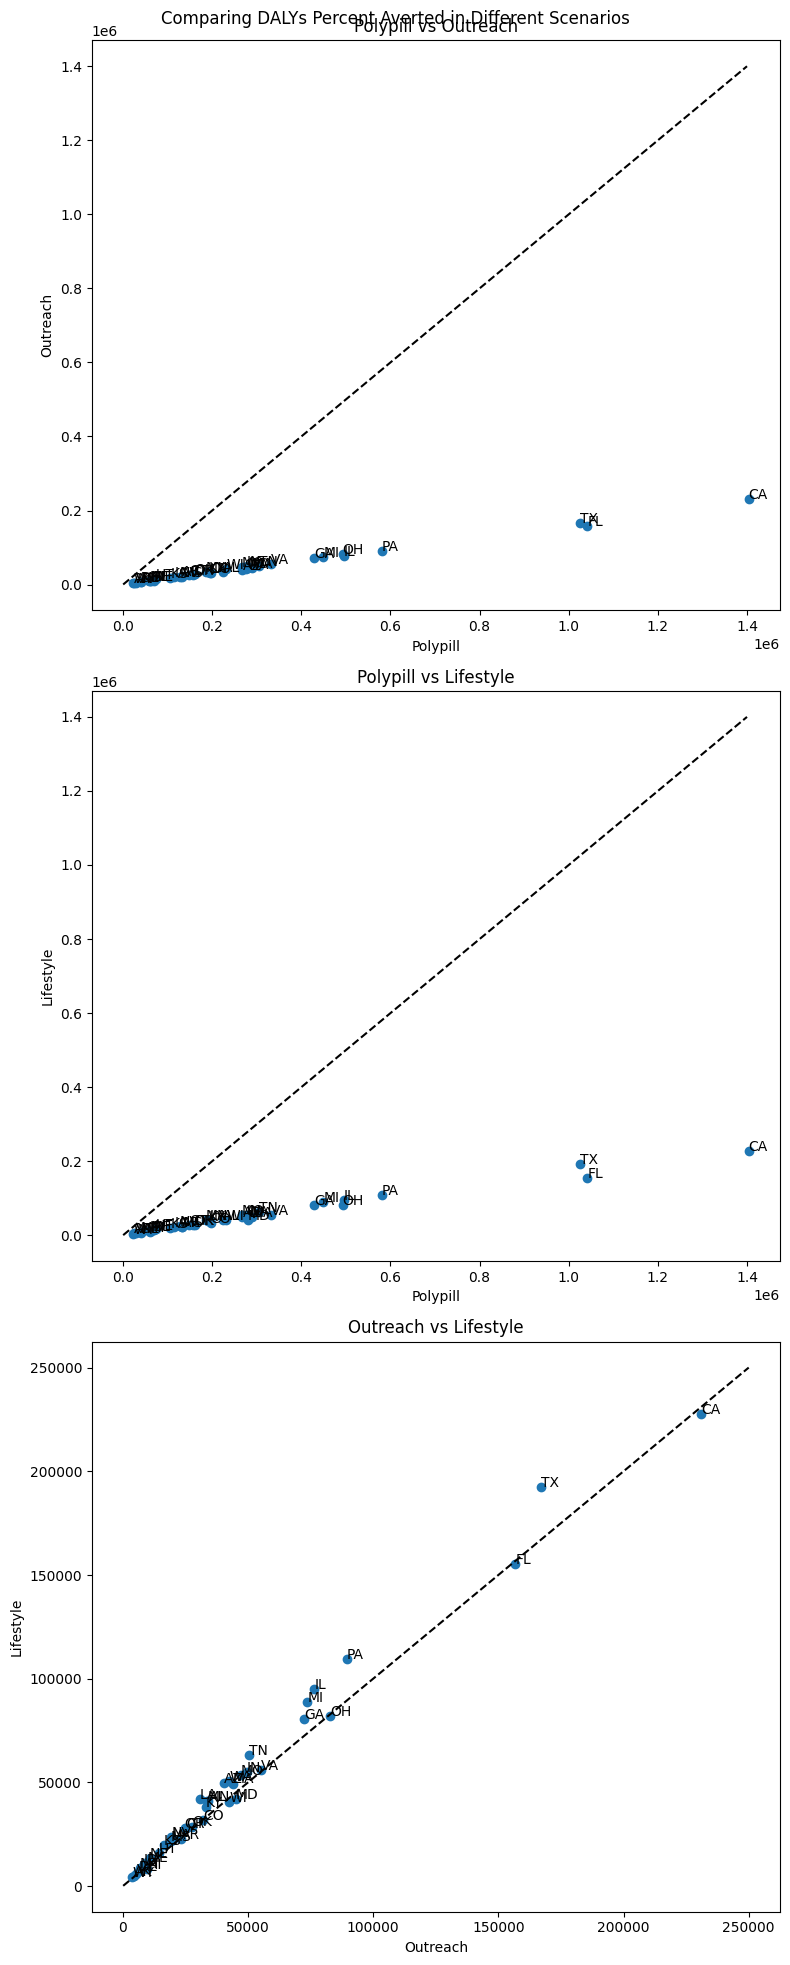

In [92]:
#%%capture
comparison_scatter_DALYs(daly_state_allyear_summ, 'DALYs', 'DALY_comparison_scatter_08_18_2023.pdf')